In [1]:
%load_ext autoreload
%autoreload 2

# Met-Encefalina

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
import molmodmt as molmodmt
import openmmtools as mmtools
from pdbfixer import PDBFixer
import mdtraj as md
import nglview as nv
from tqdm import tqdm

In [3]:
plt.style.use('ggplot')

## Definición del sistema

### Campo de fuerzas

In [4]:
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

### Trabajando el PDB original

In [5]:
system_pdb=molmodmt.load("pdb:1PLX",form="pdbfixer")

In [6]:
system_pdb.topology

<Topology; 1 chains, 5 residues, 75 atoms, 76 bonds>

In [7]:
for chain in system_pdb.topology.chains():
    print("Chain index {} with pdb id {}:".format(chain.id,chain.index))
    for residue in chain.residues():
        print("\t Residue name {}, index {}:".format(residue.name, residue.index))
        for atom in residue.atoms():
            print("\t \t Atom name {}, index {}".format(atom.name, atom.index))

Chain index A with pdb id 0:
	 Residue name TYR, index 0:
	 	 Atom name N, index 0
	 	 Atom name CA, index 1
	 	 Atom name C, index 2
	 	 Atom name O, index 3
	 	 Atom name CB, index 4
	 	 Atom name CG, index 5
	 	 Atom name CD1, index 6
	 	 Atom name CD2, index 7
	 	 Atom name CE1, index 8
	 	 Atom name CE2, index 9
	 	 Atom name CZ, index 10
	 	 Atom name OH, index 11
	 	 Atom name H, index 12
	 	 Atom name H2, index 13
	 	 Atom name H3, index 14
	 	 Atom name HA, index 15
	 	 Atom name HB2, index 16
	 	 Atom name HB3, index 17
	 	 Atom name HD1, index 18
	 	 Atom name HD2, index 19
	 	 Atom name HE1, index 20
	 	 Atom name HE2, index 21
	 	 Atom name HH, index 22
	 Residue name GLY, index 1:
	 	 Atom name N, index 23
	 	 Atom name CA, index 24
	 	 Atom name C, index 25
	 	 Atom name O, index 26
	 	 Atom name H, index 27
	 	 Atom name HA2, index 28
	 	 Atom name HA3, index 29
	 Residue name GLY, index 2:
	 	 Atom name N, index 30
	 	 Atom name CA, index 31
	 	 Atom name C, index 32
	

Es posible que el pdb carezca de algunos residuos o átomos puntuales.

In [8]:
missing_residues     = system_pdb.findMissingResidues()
nonstandard_residues = system_pdb.findNonstandardResidues()
missing_atoms        = system_pdb.findMissingAtoms()

print('Missing residues:')
print(missing_residues)
print('NonStandard residues:')
print(nonstandard_residues)
print('Missing atoms:')
print(missing_atoms)

Missing residues:
None
NonStandard residues:
None
Missing atoms:
None


En caso de encontrar residues no estandard, los podríamos reemplazar con el comando:

In [9]:
system_pdb.replaceNonstandardResidues()

En este caso no hay falta de átomos o residuos. Si lo hubiera, PDBFix puede añadirlos con el comando:

In [10]:
system_pdb.addMissingAtoms()

PDBFix puede añadir hidrógenos según pH y solvatar, como se muestra en la siguiente celda. Pero como se recomienda en la documentación de OpenMM lo vamos a hacer con Modeller. Hay que revisar el flujo de trabajo de YANK para ver como protona, solvata e ioniza.

In [11]:
if False: # Celda sólo para muestra, no para ejecutar
    system_pdb.addMissingHydrogens(pH=7.4)
    system_pdb.addSolvent(Vec3(5, 5, 5)*nanometer, positiveIon='Na+', negativeIon='Cl-', ionicStrength=0.1*molar)

Antes de solvatar y crear el sistema que simularemos con OpenMM, veamos lo que hasta ahora tenemos:

In [12]:
view=molmodmt.view(system_pdb)
view.clear()
view.add_ball_and_stick("protein")
view

NGLWidget()

In [13]:
view.render_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

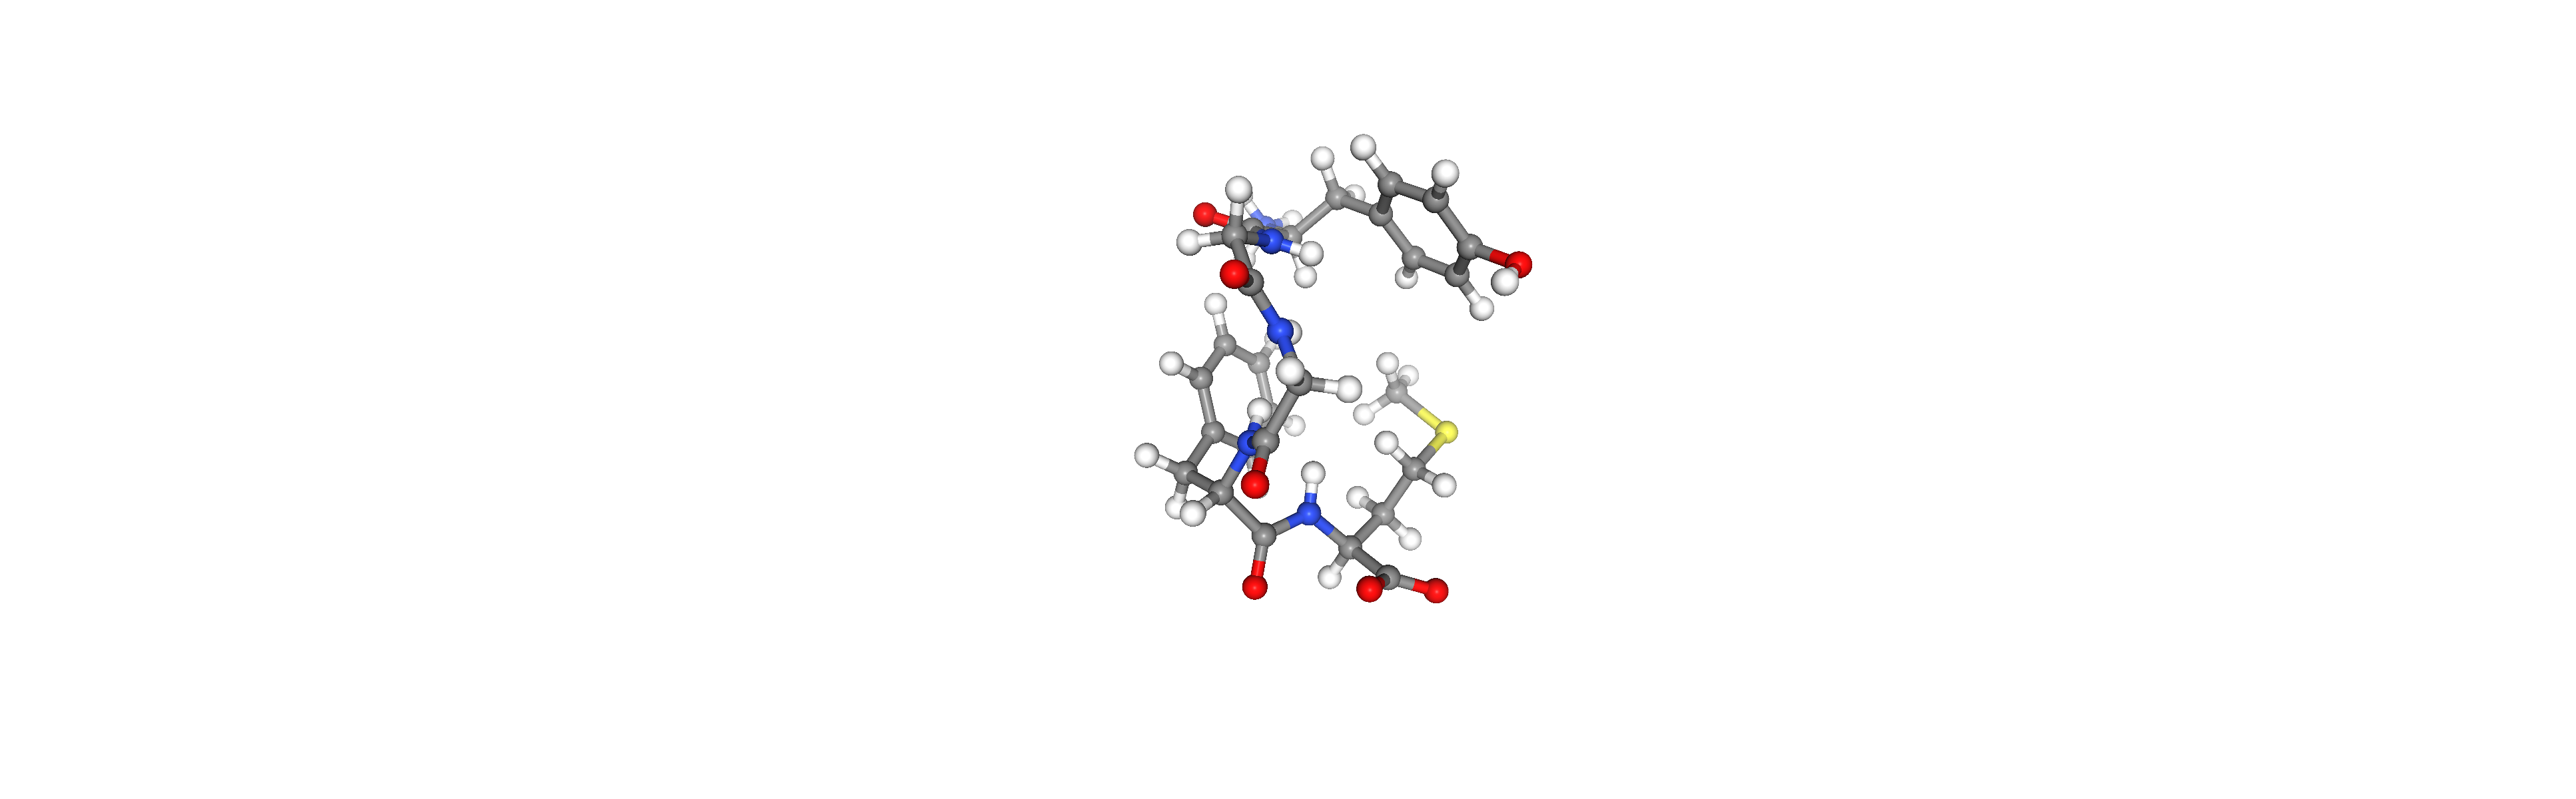

In [14]:
view._display_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

En el caso de que hubíeramos modificado el pdb original descargado directamente del Protein Data Bank, podemos escribir nuestra nueva versión del fichero:

In [15]:
molmodmt.write(system_pdb,'metenkephalin_fixed.pdb')

Podemos echarle un vistazo al fichero recien creado. Las celdas de jupyter interpretan ciertos comandos básicos del bash.

In [16]:
### Descomenta la siguiente linea para ver el contenido del fichero
#!cat metenkephalin_fixed.pdb

### Creamos la caja y solvatamos

Podemos crear la caja y solvatar directamente con PDBFixer o con otras herramientas. Pero lo vamos a hacer con otra herramienta muy util también del flujo de trabajo propuesto por OpenMM, `modeller`, para ir conociendola:

In [17]:
system_modeller = molmodmt.load(system_pdb,'modeller')

In [18]:
system_modeller.addHydrogens(forcefield,pH=7.4)

[None, None, None, None, None]

In [19]:
system_modeller.addSolvent(forcefield, model='tip3p', padding=1.4*unit.nanometers,
                           positiveIon='Na+', negativeIon='Cl-', ionicStrength=0.1*unit.molar)

Podemos si queremos, escribir un nuevo pdb del sistema la caja solvatada.

In [20]:
molmodmt.write(system_modeller,'metenkephalin_solvated.pdb')

In [21]:
### Descomenta la siguiente linea para ver el contenido del fichero
#!cat metenkephalin_solvated.pdb

Podemos también visualizar el nuevo sistema

In [23]:
view_solvated=molmodmt.view(system_modeller)
view_solvated.clear()
view_solvated.add_ball_and_stick("protein")
view_solvated.add_ball_and_stick("ion", radiusSize=0.2)
view_solvated.add_surface("all", color="cyan", opacity=0.1)
view_solvated.center()
view_solvated

NGLWidget()

In [24]:
view_solvated.render_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

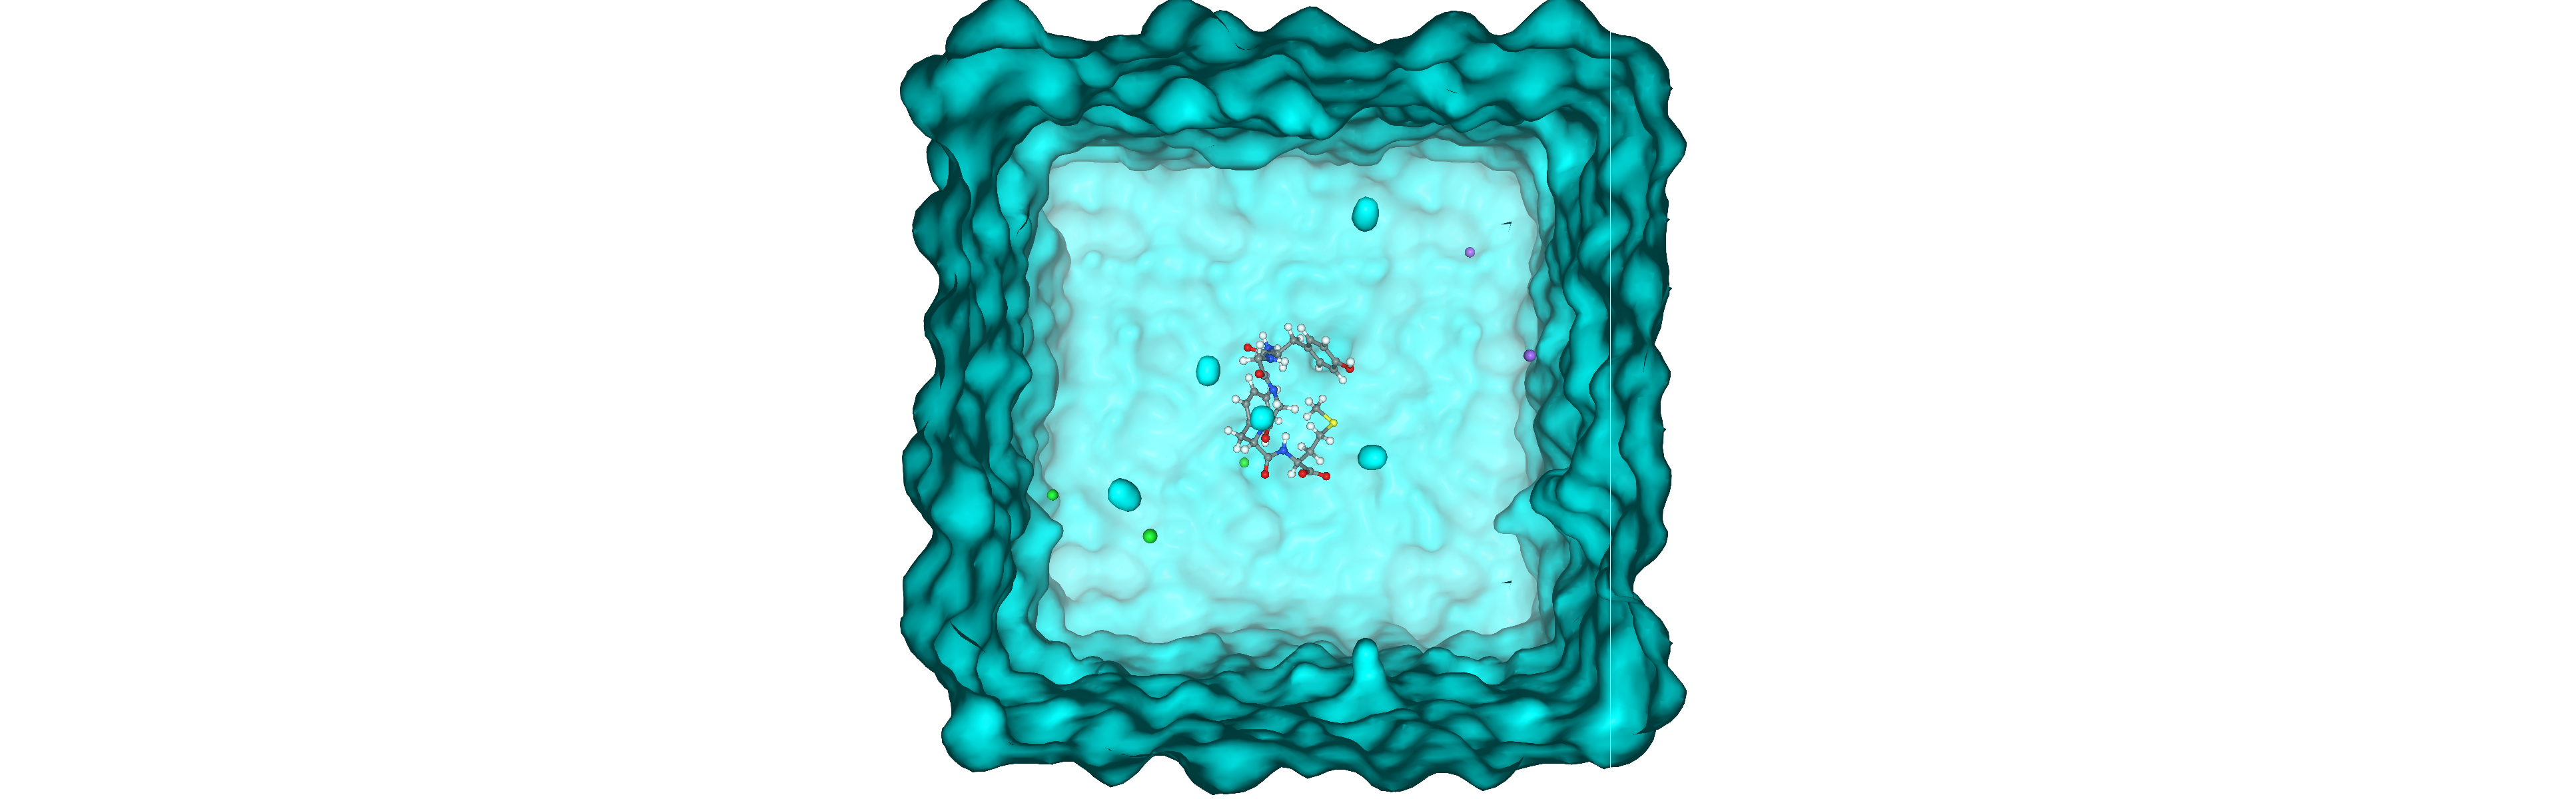

In [25]:
view_solvated._display_image() # Para que la imagen pueda ser mostrada en la versión del notebook de GitHub

Por último creamos el sistema molecular que integraremos haciendo uso de la topología creada con modeller. Las posiciones las recuperaremos mas adelante como condición inicial.

In [26]:
system = forcefield.createSystem(system_modeller.topology,
                                 nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds, rigidWater=True, ewaldErrorTolerance=0.0005)

# Estado termodinámico

In [27]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Integrador

In [28]:
friction   = 1.0/unit.picosecond
step_size  = 2.0*unit.femtoseconds
integrator = mm.LangevinIntegrator(temperature, friction, step_size)
integrator.setConstraintTolerance(0.00001)

# Parámetros de la simulación

In [29]:
simulation_time = 5.0*unit.nanoseconds
saving_time     = 0.5*unit.picoseconds

simulation_steps = simulation_time/step_size
saving_steps     = saving_time/step_size
num_steps_saved = int(simulation_steps/saving_steps)

# Plataforma de simulación

En la computadora tengo una tarjeta gráfica controlada por un driver de Nvidia. Siendo este el caso, y teniendo cuda instalado (`conda install cudatoolkit`), OpenMM detecta CUDA como plataforma para calcular:

In [30]:
for ii in range(mm.Platform.getNumPlatforms()):
    platform_name  = mm.Platform.getPlatform(ii).getName()
    platform       = mm.Platform.getPlatformByName(platform_name)
    platform_speed = platform.getSpeed()
    print('Plataforma {} con velocidad {}'.format(platform_name,platform_speed))
    del(platform_name, platform, platform_speed)

Plataforma Reference con velocidad 1.0
Plataforma CPU con velocidad 10.0
Plataforma OpenCL con velocidad 50.0


En el caso de que no aparezca CUDA en tu listado, es posible que o no tengas cudatoolkit instalado o tu entorno de conda no vea las librerías. Puedes probar a identificar el problema con la siguiente celda:

In [31]:
print(mm.Platform.getPluginLoadFailures())

('Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMCUDA.so: libcufft.so.9.2: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMRPMDCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMDrudeCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMAmoebaCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMCudaCompiler.so: libnvrtc.so.9.2: cannot open shared object file: No such file or directory')


Si el error es parecido a algo como:

>('Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMCUDA.so: libcufft.so.9.2: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMRPMDCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMDrudeCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMAmoebaCUDA.so: libOpenMMCUDA.so: cannot open shared object file: No such file or directory', 'Error loading library /home/diego/Myopt/Miniconda/miniconda3/envs/academia/lib/plugins/libOpenMMCudaCompiler.so: libnvrtc.so.9.2: cannot open shared object file: No such file or directory')

entonces es que no está instalado CUDA. Échale un ojo al notebook dedicado a este tema.

Selecciono la plataforma CUDA para simulación:

In [ ]:
platform = mm.Platform.getPlatformByName('CUDA')
#properties = {'CudaPrecision': 'mixed'}

## Simulación

Existe un objeto en OpenMM llamado `app.Simulation` que encapsula atributos y métodos propios de la simulación. Anteriormente habíamos creado nosotros el contexto de la siguiente manera:

In [ ]:
# context = mm.Context(system.system, integrator, platform)

Y con ese contexto integrábamos la dinámica y extraíamos las magnitudes de interes para ser guardadas en numpy arrays creados por nosotros a modo de reporteros. El objeto `app.Simulation` crea el objeto contexto y ofrece opciones para reportar la trayectoria:

In [ ]:
simulation = app.Simulation(system_modeller.topology, system, integrator, platform) # properties)

# Reporteros y arrays de salida

In [ ]:
num_atoms  = system.topology.getNumAtoms()
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,num_atoms,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,num_atoms,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [ ]:
initial_positions  = system.positions
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system.system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [ ]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [ ]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

# Análisis de resultados

Accediendo a las posiciones:

In [ ]:
atom_index = 10 # Por ejemplo del átomo 10
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,atom_index,ii])
    plt.ylabel(ylabel+' ('+str(positions.unit)+')')
    plt.xlabel('time ('+str(times.unit)+')')
    plt.show()

Representando las energías cinética y potencial:

In [ ]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,kinetic_energies[:])
plt.ylabel('Kinetic Energy ('+str(kinetic_energies.unit)+')')
plt.xlabel('time ('+str(times.unit)+')')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,potential_energies[:])
plt.ylabel('Potential Energy ('+str(potential_energies.unit)+')')
plt.xlabel('time ('+str(times.unit)+')')
plt.show()

Represento la trayectoria centrada y fitteada según los átomos de la cadena principal:

In [ ]:
mdtraj_topology = md.Topology.from_openmm(system.topology)
mdtrajectory    = md.Trajectory(positions/unit.nanometers, mdtraj_topology)

In [ ]:
mdtrajectory = mdtrajectory.center_coordinates()
mdtrajectory = mdtrajectory.superpose(reference=mdtrajectory, frame=0, 
                                      atom_indices=mdtrajectory.topology.select("backbone"))

In [ ]:
view_traj = nv.show_mdtraj(mdtrajectory)
view_traj

Represento el RMSD de la trayectoria fitteada respecto del frame 0 según los átomos de la cadena principal

In [ ]:
rmsd = md.rmsd(mdtrajectory, mdtrajectory, atom_indices=mdtrajectory.topology.select("backbone"))

In [ ]:
plt.rcParams['figure.figsize'] = 18, 4
plt.plot(times,rmsd[:])
plt.ylabel('RMSD (nm)')
plt.xlabel('time ('+str(times.unit)+')')
plt.show()

Represento los pares de ángulos dihedros phi y psi visitados por la trayectoria sobre el plot de ramachandran.

In [ ]:
phi   = md.compute_phi(mdtrajectory)
psi   = md.compute_psi(mdtrajectory)
omega = md.compute_omega(mdtrajectory)

In [ ]:
plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(phi[1],psi[1])
plt.ylabel('PSI')
plt.xlabel('PHI')
plt.ylim(-np.pi,np.pi)
plt.xlim(-np.pi,np.pi)
plt.show()